# ПРОЕКТ: BOOKING

## ЗАДАЧА: построение модели, предсказывающей рейтинг отеля на основе предоставленных данных.

## Загрузка библиотек

In [511]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd
import os
import numpy as np

# импортируем кодировщик
import category_encoders as ce 

# импортируем тесты для отбора данных:
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif, mutual_info_classif

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline

# Загружаем инструменты для разделения моделирования и метрик:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 
from sklearn.model_selection import train_test_split

# для нормализации, стандартизации
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/sapozhok/sf-booking/data_world.csv
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [512]:
pip install geopy 

Note: you may need to restart the kernel to use updated packages.


In [513]:
from geopy.distance import geodesic as GD 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [514]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [515]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## ЗАГРУЗКА ДАННЫХ
Первоначальная версия датасета содержит 17 полей со следующей информацией:

   * hotel_address — адрес отеля;

   * review_date — дата, когда рецензент разместил соответствующий отзыв;

   * average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

   * hotel_name — название отеля;

   * reviewer_nationality — страна рецензента;

   * negative_review — отрицательный отзыв, который рецензент дал отелю;

   * review_total_negative_word_counts — общее количество слов в отрицательном отзыв;

   * positive_review — положительный отзыв, который рецензент дал отелю;

   * review_total_positive_word_counts — общее количество слов в положительном отзыве.

   * reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;

   * total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;

   * total_number_of_reviews — общее количество действительных отзывов об отеле;

   * tags — теги, которые рецензент дал отелю;

   * days_since_review — количество дней между датой проверки и датой очистки;

   * additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.

   * lat — географическая широта отеля;

   * lng — географическая долгота отеля.



In [516]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
hotels = pd.read_csv(DATA_DIR+'/hotels_train.csv')  # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')  # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')  # самбмишн

Данные со странами с сайта [worldpopulationreview.com](https://worldpopulationreview.com/country-rankings/how-many-countries-are-there). Можно просто скачать дата сет. 

In [517]:
# Подгрузим данные из загруженные из внешних источников
df_world=pd.read_csv('/kaggle/input/d/sapozhok/sf-booking/data_world.csv')
df_world.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   place       234 non-null    int64  
 1   pop2023     234 non-null    float64
 2   growthRate  234 non-null    float64
 3   area        234 non-null    float64
 4   country     234 non-null    object 
 5   cca3        234 non-null    object 
 6   cca2        233 non-null    object 
 7   ccn3        234 non-null    int64  
 8   region      234 non-null    object 
 9   subregion   234 non-null    object 
 10  landAreaKm  234 non-null    float64
 11  density     234 non-null    float64
 12  densityMi   234 non-null    float64
 13  Rank        234 non-null    int64  
 14  continent   234 non-null    object 
 15  rank        234 non-null    int64  
dtypes: float64(6), int64(4), object(6)
memory usage: 29.4+ KB


In [518]:
#hotels = pd.read_csv('hotels.csv')
#hotels.info()

In [519]:
# посмотрим на наши данные трейновую версию:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

В наших данных 17 признаков, в т.ч. 9 в числовом формате, ключая целевцю переменную (**reviewer_score**), и 8 в строковом, из который **review_date** представляет собой дату. Все категориальные признаки необходимо трансформировать в числовые либо удалить, поскольку наша модель может принимать только числовые значения.

## Удаление дубликатов и заполнение пропусков

Проверим данные на наличие дубликатов  и удалим их. В тестовой части на Kaggle удалять дубликаты будем только в трейне, т.к. в тестовой части необходимо сохранить последовательность и количество строк.

In [520]:
dupl_columns = list(hotels.columns)
mask = hotels.duplicated(subset=dupl_columns)
df_duplicates = hotels[mask]
print(f'Число найденных дубликатов: {df_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [521]:
# проверим по отелям, где больше дубикатов:
df_duplicates.hotel_name.value_counts()

H tel Concorde Montparnasse         211
H tel Baume                          49
Hotel Le Sainte Beuve                33
Villa Eugenie                         8
Pertschy Palais Hotel                 1
The Bloomsbury Hotel                  1
Hotel Da Vinci                        1
Mercure Paris Centre Tour Eiffel      1
Park Plaza Vondelpark Amsterdam       1
Fletcher Hotel Amsterdam              1
Name: hotel_name, dtype: int64

Удаляем дубликаты из датаета и делаем быструю проверку на наличие пропусков.

In [522]:
hotels= hotels.drop_duplicates(subset=dupl_columns)
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

Пропуски встречются только в двух столбах: широта(**lat**) и долгота(**lng**) отеля. Проверим на совпадение эти данные: 

In [523]:
a=set(hotels[hotels['lat'].isnull()].index)
b=set(hotels[hotels['lng'].isnull()].index)
print(len(a-b))

0


Индексы строк совпадают, следовательно, пропуски по этим столбац присутствуют одних и тех же строках.
Для заполнения этих строк разберем признак адрес отеля (**hotel_address**), создадим столбцы с городом и страной отеля и по координатам города заполним пропуски в датасете. Но для начала сделаем копию датафрейма для удобства работы.

In [524]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(hotels, sort=False).reset_index(drop=True) # объединяем

In [525]:
# адреса с пропусками:
df['hotel_address'][df.lng.isnull()].value_counts()

Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
4 rue de la P pini re 8th arr 75008 Paris France               290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria            147
Bail n 4 6 Eixample 08010 Barcelona Spain                      146
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria             93
Hasenauerstra e 12 19 D bling 1190 Vienna Austria               61
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria        57
23 Rue Damr mont 18th arr 75018 Paris France                    55
Paragonstra e 1 11 Simmering 1110 Vienna Austria                49
20 Rue De La Ga t 14th arr 75014 Paris France                 

In [526]:
df['hotel_address'].value_counts()

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

In [527]:
# выделяем из адреса город и страну отеля:
df['hotel_country']=df['hotel_address'].apply(lambda x: str(x.split(' ')[-1:])[2:-2])
df['hotel_city']=df['hotel_address'].apply(lambda x: str(x.split(' ')[-2:-1])[2:-2])
print(df['hotel_country'].value_counts())
print(df['hotel_city'].value_counts())

Kingdom        262300
Spain           60149
France          59626
Netherlands     57212
Austria         38938
Italy           37206
Name: hotel_country, dtype: int64
United       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64


Получается у нас всего шесть стран и скорее всего шесть городов. Проверим, сколько раз встречается слово "London" в столбце с адресами отелей:

In [528]:
df.hotel_address[(df['hotel_address'].str.contains(r'\bLondon'))
                 & (df['hotel_country'] == 'Kingdom')].count()

262300

In [529]:
df.hotel_address[df['hotel_country'] == 'Kingdom'].count()

262300

Следовательно, все отели из Великобритании находятся в Лондоне. Заменим страну *Kingdom* на *United Kingdom* и все города с пометкой *United* на *Londoт*.

In [530]:
df['hotel_country'] = df['hotel_country'].apply(
    lambda x: 'United Kingdom' if x == 'Kingdom' else x)

In [531]:
df['hotel_city'] = df['hotel_city'].apply(
    lambda x: 'London' if x == 'United' else x)

Из открытых источников  соберем данные по шести городам по долготе и широте и заполним пропуски:

In [532]:
values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}

df['lat'] = df[['hotel_city', 'lat']].apply(
    lambda x: values_lat[x.hotel_city] if np.isnan(x.lat) else x.lat, axis=1)
df['lng'] = df[['hotel_city', 'lng']].apply(
    lambda x: values_lng[x.hotel_city] if np.isnan(x.lng) else x.lng, axis=1)

In [533]:
df.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
hotel_country                                 0
hotel_city                                    0
dtype: int64

Все видимые пропуски заполнены, перейдем к избавлению от нечисловых признаков и созданию новых на их основе.

Касательно дубликатов: на отель H tel Concorde Montparnasse уже следует обратить внимание, так как у него наибольшее количество выявленных дубликатов.

# Анализ признаков и создание новых на их основе


## Признаки типа 'int' и 'float'

In [534]:
# список числовых признаков:
num_columns = [s for s in hotels.columns if (
    hotels[s].dtypes == 'int64') or (hotels[s].dtypes == 'float64')]
num_columns

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng',
 'sample']

In [535]:
# список числовых признаков без целевой переменной:
num_cols= ['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng']

In [536]:
# стат. характкристики числовых признаков:
df.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,49.432701,2.893855,0.74985,6.296715
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,3.461246,4.668997,0.43310,3.902967
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.00000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.213305,-0.143372,0.00000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.019886,1.00000,7.900000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,51.516288,4.841163,1.00000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.00000,10.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


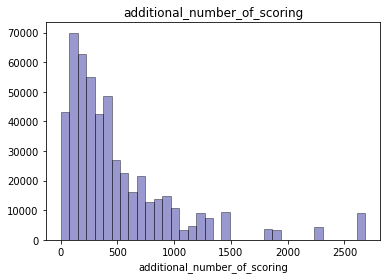

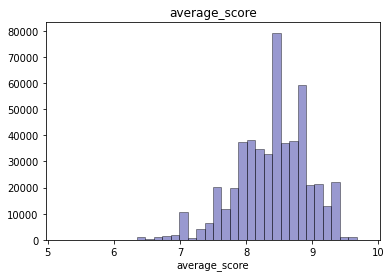

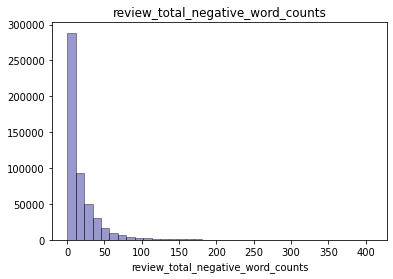

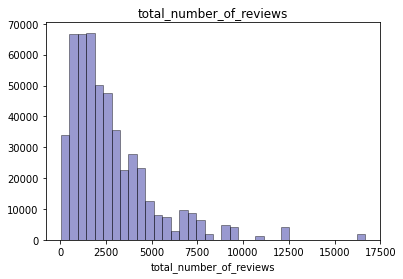

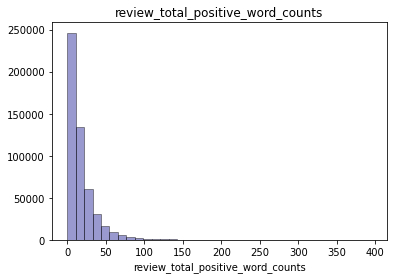

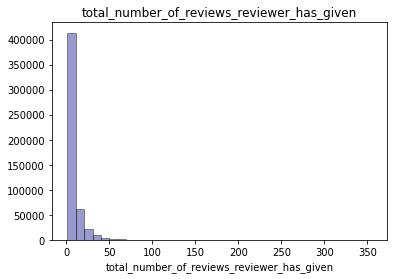

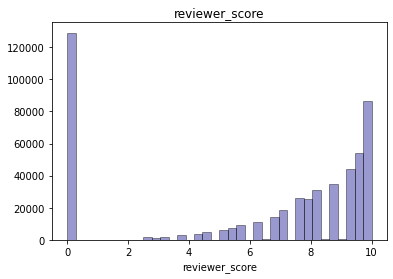

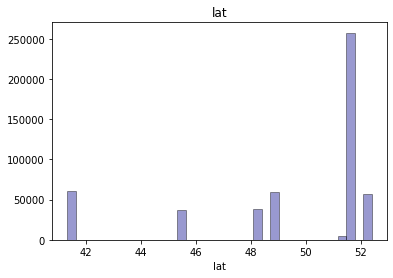

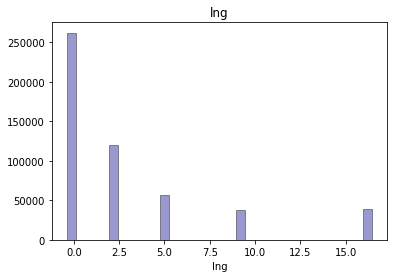

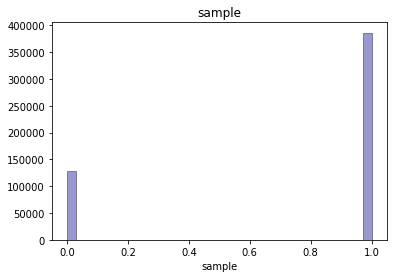

In [537]:
# построим распределение по каждому числовому признаку:
for i in num_columns:
    plt.figure()
    sns.distplot(df[num_columns][i], kde=False, rug=False, color='darkblue', bins=int(
        180/5), hist_kws={'edgecolor': 'black'})
    plt.title(i)
    plt.show()

#### Предварительное распределение числовых признаков относительно целевой переменной

<AxesSubplot:>

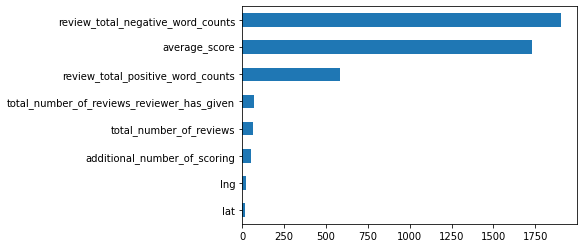

In [538]:
imp_num = pd.Series(f_classif(
    df[df['sample'] == 1][num_cols], df[df['sample'] == 1]['reviewer_score'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

**Первые выводы по числовым данным:**

* **additional_number_of_scoring**: количество оценок без отзывов и без проверки распределяется от 1(min) до 2682 (max), причем основое количество оценок сосредоточено в интервале от 170 до 660. Безусловно, показатель в 2682 оценки относится к выбросам, однако в нашем случае мы не можем избавиться от этих выбросов, поскольку это нарушит структуру данных. Касательно важности влияния на целевую переменненную (*reviewer_score*) находится далеко не на первом месте. Данный при знак выражен в целых числах, скорее всего относится к непрерывным числовым признакам.

* **average_score** -средний балл отеля отнесем к числовым дискретным признакам, следовательно его нужно впоследствии отнести к категориальным признакам, поскольку он не является непрерывным. Средняя популярная оценка находится на уровне 8.4; признак распределен от 5.2 до 9.8. Во всем признаке низких оценок нет, поскольку сам показатель усредненный, также нет значений выше и ниже пороговых (т.е. бпльше 10 и меньше 0). Занимает второе значение по влиянию из первоначальных числовых признаков.

*  **total_number_of_reviews**- общее количество действительных отзывов распределяется от 43 до 16670, что явно свидетельствует о наличии выбросов сос стороны максимума, как и в певом признаке. Наиболее популяное количество отзывов располагается в границах от 1100 до 3600. ПРизнак числовой непрерывный. Оказывает не очень большое влияние на целевую переменную.

* **review_total_positive_word_counts** и **review_total_negative_word_counts** количество положительных и отрицательных слов в отзывах. Оба признака числовые непрерывные. Имеют похожие распределения. Рецензенты, оставляющие положительные отзывы пишут в отзыве в среднем на пару слов больше. По значимости, отрицательные отзывы сильне влияют рейнинг отеля, но в любом случае, оба первоначальных признака достаточно значимы и занимают третье и первое место по влияюню на целевую переменную.

* **total_number_of_reviews_reviewer_has_given** количество отзывов, которые рецензенты дали в прошлом. Не совсем понятно, к каким рецензентам это относится: к тем, чьи оценки и отзывы представлены в данных или вообще к каким-то рецензентам. Признак числовой непрерывный имеет почти такое же влияние как и общее количество действительных отзывов, однако стоит отметить, что также имеются выбросы, поскольку самое популяное количество отзывов находится в интервале от 1 до 8, тогда как максимальное значение признака 355.

* **lat** и **lng** географическая широта отеля и географическая долгота отеляю Несмотря на выраженные в числах значения - это дискретный  признак, его лучше отнести к категориальным, поскольку из распределения видно, что у нас 6,5 значений по широте и 5 значений по долготе. Это говорит о том, что наши отели сконцентированы в 6-7 городах и/или странах. Большинство отзывов касается отелей на нулевой долготе (район Лондона).  Это подтвержается нашими заполнениями пропусков: 6 стран и 6 невропейских городов.

* **reviewer_score** оценка отеля, которую рецензент поставит на основании своего опыта- целевая переменная. Это дискретный числовой признак. Нет значений ниже 2.5 и выше 10(максимум). Самая популярная оценка - достаточно высокая - 8.8. Значит, рецензенты предпочитают в основном оставлять хорошие отзывы или отели могут их кооректировать (Например, удвоением положительных отзывов (см. раздел удаление дубликатов)).

*Примечание*: все выводы сделаны на основе данных hotels, который является трейновой частью на kaggle. Точные значения показателей на полных данных могут немного измениться, но это не повлияет на выводы.

## Признаки типа 'object'

Наша задача преобразовать признаки в числовые: дискретные или непрерывные. Или создать на их основове новые признаки с типом 'int' или 'float'.

In [539]:
#  Признаки типа 'object'
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review',
 'hotel_country',
 'hotel_city']

### hotel_address

Ранее, по адресу отеля мы добавили два столбца: город и страна отеля. Можно было бы по адресу определить точные координаты отеля для заполнения пропусков в столбцах с широтой и долготой, но пока остановимся на вариантне заполнения пропусков по центу города отеля. И данный признак нам становится не очень нужен. Он пойдет под удаление. Но на основе столбцов можно создать новый признак- расстояние от отеля до цента города.

Добавим в дата сет признак расстояние от центра города до отеля. Для этого временно создадим столбцы с координатами городов, где находятся наши отели. Затем с помошью GEOPY рассчитаем расстояние от отеля до центра города.

In [540]:
df['city_lat'] = df['hotel_city'].apply(lambda x: values_lat[x])
df['city_lng'] = df['hotel_city'].apply(lambda x: values_lng[x])
df['distance_to_center'] = df.apply(lambda row: GD(
    (row.city_lat, row.city_lng), (row['lat'], row['lng'])).km, axis=1)

In [541]:
# удалим признаки с широтой и долготой города отеля:
df = df.drop(['city_lng', 'city_lat'], axis=1)

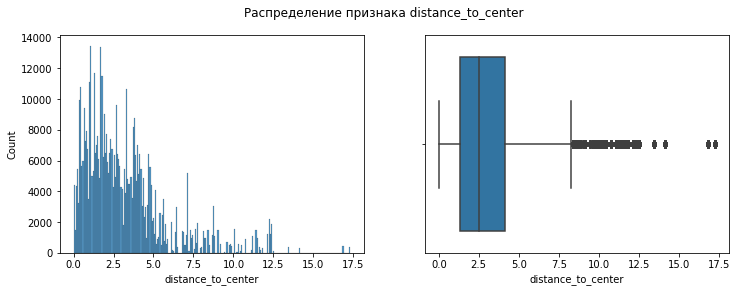

In [542]:
# Полученный признак числовой, непрерывный, посмотрим на его распределение:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.suptitle('Распределение признака distance_to_center')
histplot = sns.histplot(x=df['distance_to_center'], ax=axes[0])
boxplot = sns.boxplot(x=df['distance_to_center'], ax=axes[1])

По признаку видно, все отели находятся в черте названных городов (17,5 км от центра), что соответствует действительности. Значит, расстояния посчитаны верно. Выбросы по коробчатой диаграмме можно не принимать во внимание, т.к некоторые отели вполне могут находиться в 17-20 км от центра города, тем более речь идет о крупных европейских городах-миллионниках.


Можно еще закодировать дополнительно закодировать отели по городам или странам, т.к. признак страны и города отеля, созданные нами ранее пойдут под удаление. Получили категориальный признак.

In [543]:
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(df[['hotel_city']]) 
data_bin.columns = ['hotel_city_cod'] # переименуем закодированный столбец
df = pd.concat([df, data_bin], axis=1)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64


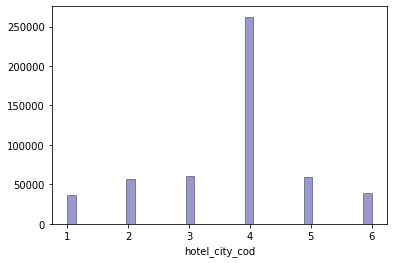

In [544]:
sns.distplot(df['hotel_city_cod'], kde=False, rug=False, color='darkblue', bins=int(
        180/5), hist_kws={'edgecolor': 'black'})
print(df['hotel_city'].value_counts())

Больше всего отзывов оставлено об отелях в Лондоне (почти 75% от общего числа), остальные 5 городов пользуются примерно равным спросом у рецензентов.

### review_date и days_since_review

Признак - дата отзыва (**review_date**) можно преобразовать во временной формат. А затем сравнить с количеством дней между датой отзыва и датой очистки (**days_since_review**). Последний признак является числовым, если убрать слов *days* из строк.

In [545]:
df['review_date'] = pd.to_datetime(df['review_date'], format='%m/%d/%Y')

In [546]:
df['days_since_review']=df['days_since_review'].apply(lambda x: int(''.join(x.split(' ')[:1])))

In [547]:
print(df.review_date.max()-df.review_date.min())
print(df.days_since_review.max()-df.days_since_review.min())

730 days 00:00:00
730


array([[<AxesSubplot:title={'center':'review_date'}>,
        <AxesSubplot:title={'center':'days_since_review'}>]], dtype=object)

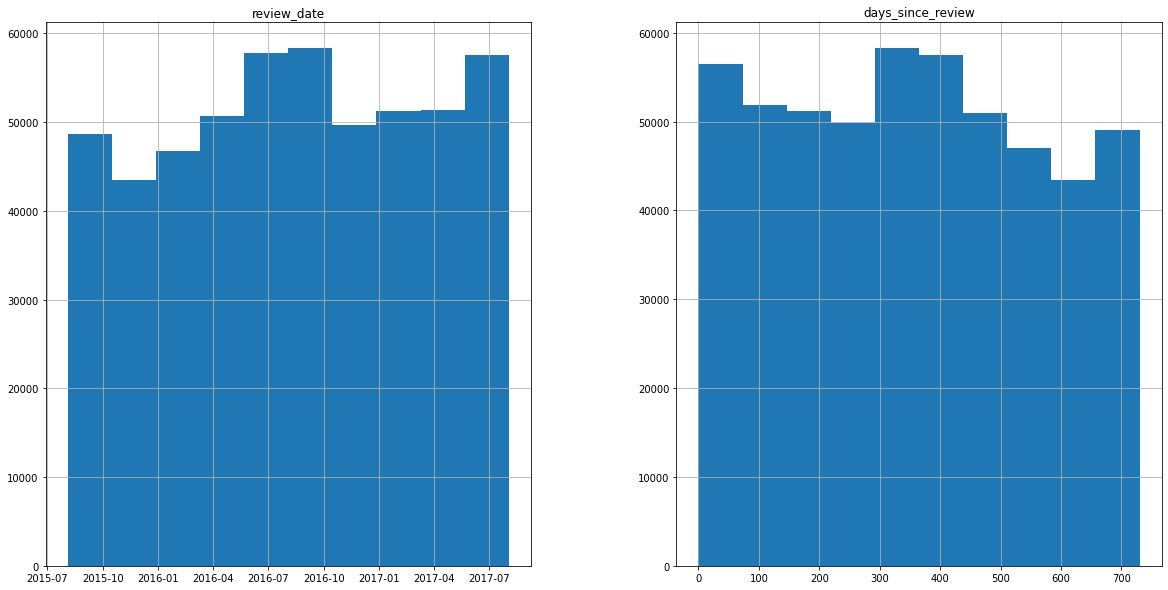

In [548]:
df[['review_date','days_since_review']].hist(figsize=(20,10))

Графики практически равнозначны, что говорит об одинаковости признаков. На последнюю дату отзывов приходится 0 дней. Поэтому для модели оставим количество дней от отзыва до очистки, если ничего не придумаем с датой.

Перед удалением столбца с датой, созждадим признак месяц подачи отзыва (**review_month**) и день недели (**review_weekday**) и посмотрим на взаимосвязь с количеством дней:

In [549]:
df['review_month'] = df['review_date'].dt.month
df['review_weekday'] = df['review_date'].dt.weekday

array([[<AxesSubplot:title={'center':'review_month'}>,
        <AxesSubplot:title={'center':'days_since_review'}>]], dtype=object)

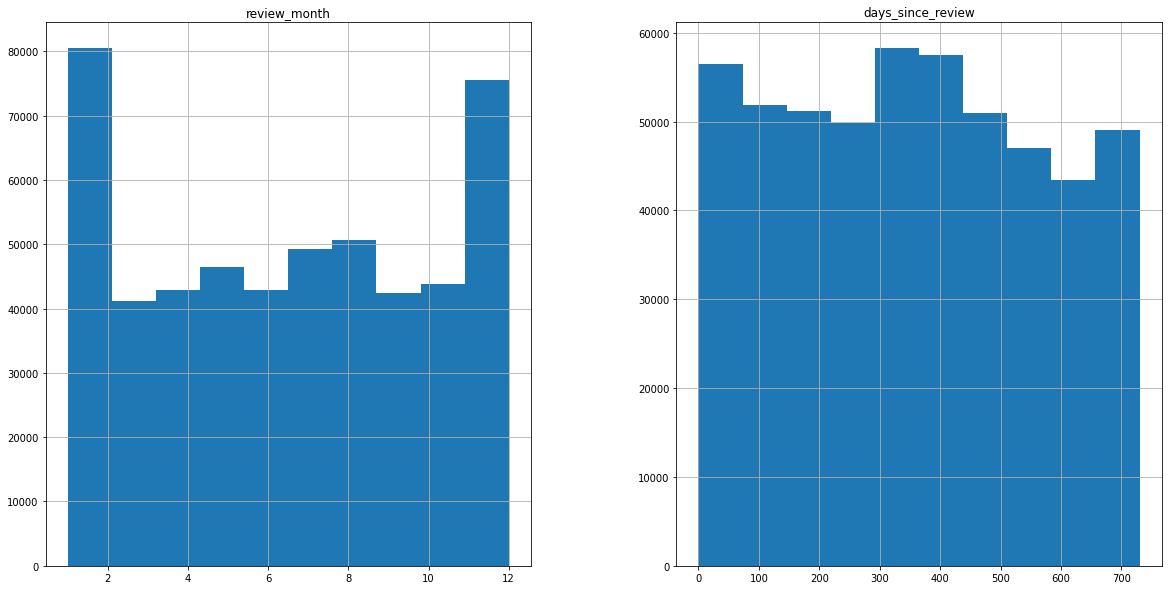

In [550]:
df[['review_month','days_since_review']].hist(figsize=(20,10))

array([[<AxesSubplot:title={'center':'review_weekday'}>,
        <AxesSubplot:title={'center':'days_since_review'}>]], dtype=object)

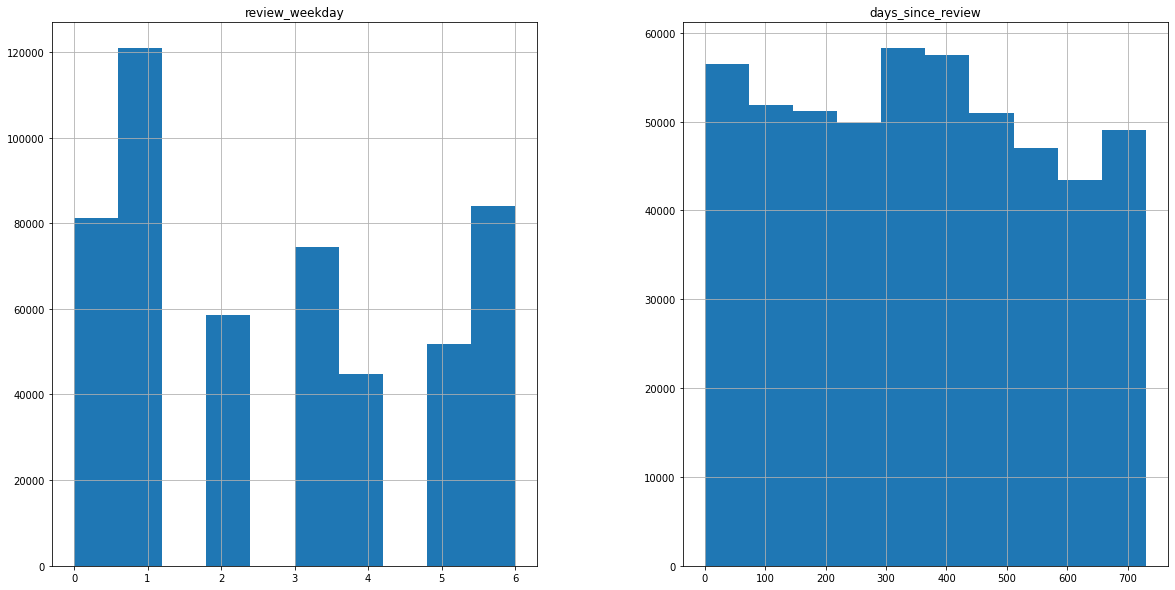

In [551]:
df[['review_weekday','days_since_review']].hist(figsize=(20,10))

Посмотрим на распределение полученных признаков:

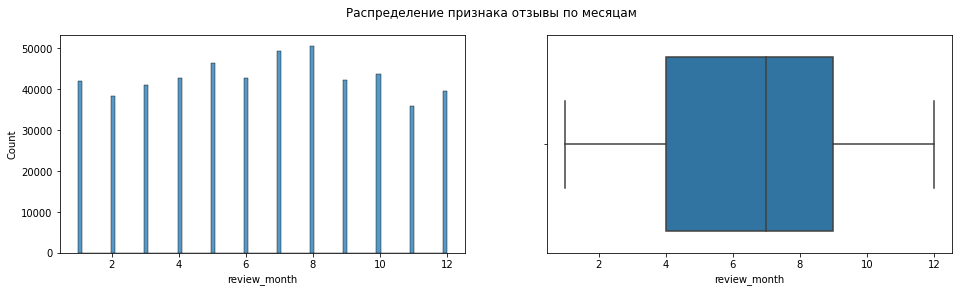

In [552]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle('Распределение признака отзывы по месяцам')
histplot = sns.histplot(x=df['review_month'], ax=axes[0])
boxplot = sns.boxplot(x=df['review_month'], ax=axes[1])

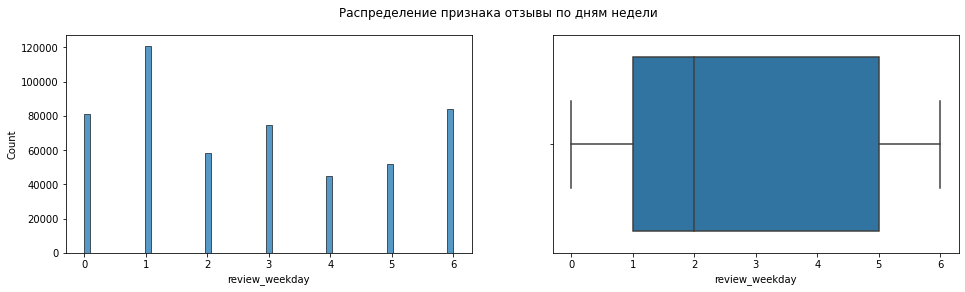

In [553]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle('Распределение признака отзывы по дням недели')
histplot = sns.histplot(x=df['review_weekday'], ax=axes[0])
boxplot = sns.boxplot(x=df['review_weekday'], ax=axes[1])

Максимальное количество отзывов приходится на июль и август, что соответствует действительности, поскольку летом в эти месяцы как правило все уходят в отпуск. 

Отзывы пишутся в основном по вторникам (0-понедельник, 6 - воскресенье), немного меньше в воскресенье и понедельник, пока свежи впечатления после отдыха.

Выбросов, по понятным причинам у нас нет, поскольку данный признак категориальный в числовом формате.
Полученные признаки - категориальные, куда они и будут отнесены на этапе отбора признаков.


In [554]:
# Поскольку два признака практически полность повторяют друг друга, удалим дату:
df=df.drop('review_date', axis=1)

### hotel_name

Возможно нужно посмотреть сети отелей и создать признак: сетевой отель или нет. Сети отелей просматривала практически вручную (```df.hotel_name[(df['hotel_name'].str.contains(r'\bNH Collection'))]```), выбрав самые популярные 80 строк и проверив первые два слова (заодно ознакомилась с европейскими сетями). Получился примерный список сетей.

In [555]:
hotel_chain = ['Ritz', 'Millennium', 'Hilton', 'Hyatt', 'Park Plaza', 'Four Seasons', 'Sheraton',
               'Mandarin Oriental', 'Radisson', 'Best Western', 'Club Quarters', 'Mercure', 
               'citizenM', 'Marriott', 'Novotel','WestCord' , 'Montcalm','Pullman', 'NH Collection']

In [556]:
# Создадим новый бинарный признак, где 1- отель сетевой, 0- отель не сетевой:
df['hotel_chain']=df.hotel_name.str.contains('|'.join(hotel_chain))
df['hotel_chain']=df['hotel_chain'].apply(lambda x: 1 if x is True else 0)

In [557]:
df['hotel_chain'].value_counts(normalize=True)

0    0.73723
1    0.26277
Name: hotel_chain, dtype: float64

Больше четверти отелей сетевые, впоследствии посмотрим как наш признак будет влиять на модель. Полученный признак категориальный.

Закодируем все отели порядковым кодированием и получим признак **hotel_cod**, а сам признак **hotel_name** пойдет под удаление.

In [558]:
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(df[['hotel_name']]) 
data_bin.columns = ['hotel_cod'] # переименуем закодированный столбец
df = pd.concat([df, data_bin], axis=1)

### negative_review and positive_review

Данные признаки представляют собой тексты отрицательных и положительных отзовов. С помощью анализатора с `SentimentIntensityAnalyzer()`составим дополнительные четере признака для каждого столбца с отзывами.

In [559]:
sent_analyzer = SentimentIntensityAnalyzer()
# создадим признак словарь с показателями негативных отзывов:
df['scсores_negrev'] = df['negative_review'].apply(lambda review: sent_analyzer.polarity_scores(review))
# на основе словаря создаем 4 признака:
df['neg_negrev']=df['scсores_negrev'].apply(lambda score_dict: score_dict['neg'])
df['neu_negrev']=df['scсores_negrev'].apply(lambda score_dict: score_dict['neu'])
df['pos_negrev']=df['scсores_negrev'].apply(lambda score_dict: score_dict['pos'])
df['compound_negrev']  = df['scсores_negrev'].apply(lambda score_dict: score_dict['compound'])        

In [560]:
# Аналогично предыдушему пункту создани 4 признака по положительным отзовам:
df['scсores_posrev'] = df['positive_review'].apply(lambda review: sent_analyzer.polarity_scores(review))
df['neg_posrev']=df['scсores_posrev'].apply(lambda score_dict: score_dict['neg'])
df['neu_posrev']=df['scсores_posrev'].apply(lambda score_dict: score_dict['neu'])
df['pos_posrev']=df['scсores_posrev'].apply(lambda score_dict: score_dict['pos'])
df['compound_posrev']  = df['scсores_posrev'].apply(lambda score_dict: score_dict['compound'])    

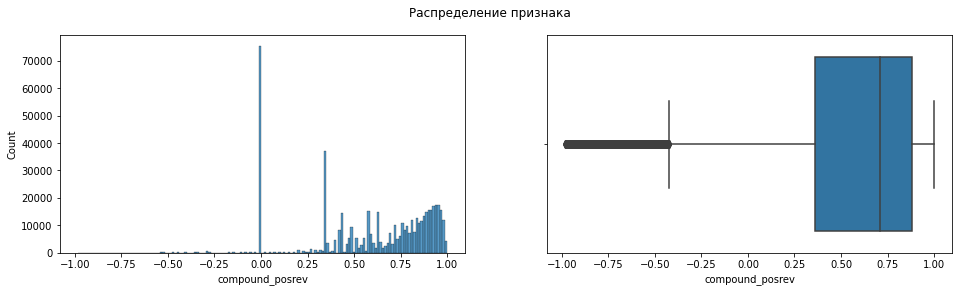

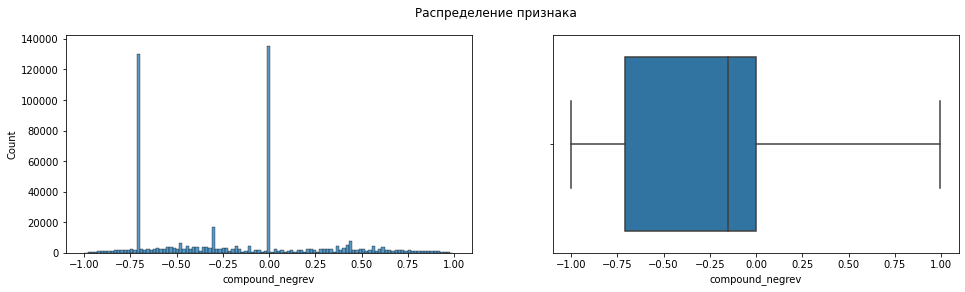

In [561]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle('Распределение признака ')
histplot = sns.histplot(x=df['compound_posrev'], ax=axes[0])
boxplot = sns.boxplot(x=df['compound_posrev'], ax=axes[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle('Распределение признака ')
histplot = sns.histplot(x=df['compound_negrev'], ax=axes[0])
boxplot = sns.boxplot(x=df['compound_negrev'], ax=axes[1])

Среди положительных отзывов встечаются и отрицательные, причем с максимальной оценкой (до -1). Медианна примерно на уровне 0,7, что похоже на правду.

Среди отрицательных отзывов, основное количество имеет отценку от -0,75 до 0(ближе к нейтральной оценке), что также не притоверечит действительности, в любом случае общую оценку по отзывам мы оставим, т.к. название столца никак не повлияет на нашу модель.

Все полученные отзывы отнесем к числовым непрерывным.

### reviewer_nationality

На основе этого признака создадим бинарный признак **native_hotel**: является ли страна отеля родиной (или постоянным местом проживания) рецензента; для этого сравним столбцы со страной отеля и страной рецензента: 1-означает да, 0-нет

In [562]:
# удираем лишние пробелы из столбца со странами рецензентов перед сравнением:
df['reviewer_nationality'] = df['reviewer_nationality'].apply(
    lambda x: x.strip())
# создаем столбец на основе условия сравнения столбцов:
df['native_hotel'] = np.where(
    df['hotel_country'] == df['reviewer_nationality'], 1, 0,)

In [563]:
# проверяем, что получилось:
df['native_hotel'].value_counts(normalize=True)

0    0.653913
1    0.346087
Name: native_hotel, dtype: float64

Почти 35% всех рецензентов проживают в стране, где находится отель. 

Также на основе этого признака, можно распределить всех рецензентов по частям света: Европа, Азия, Южная и Севереая Америки и т.д. Для этого нам понадяобятся данные со странами с сайта [worldpopulationreview.com](https://worldpopulationreview.com/country-rankings/how-many-countries-are-there). Можно скачать дата сет. Сравним список стран наших рецензентов со списком реально существующих стран. 

In [564]:
#df_world=pd.read_csv('data_world.csv') # создаем дата сет со скаченными данными
counties = list(df_world['country'])     # создаем список всех из дата сета
# список стран всех рецензентов
list_nationality = list(df.reviewer_nationality.value_counts().index)
print('Количество стран рецензентов: {}'.format(len(list_nationality)))
print('Количество стран в мире {}'.format(len(counties)))

Количество стран рецензентов: 227
Количество стран в мире 234


In [565]:
df_world.head()

,place,pop2023,growthRate,area,country,cca3,cca2,ccn3,region,subregion,landAreaKm,density,densityMi,Rank,continent,rank
0,12,45606480.0,0.01566,2381741.0,Algeria,DZA,DZ,12,Africa,Northern Africa,2381741.0,19.1484,49.5943,34,Africa,34
1,24,36684202.0,0.03077,1246700.0,Angola,AGO,AO,24,Africa,"Middle Africa, Sub-Saharan Africa",1246700.0,29.4250,76.2109,42,Africa,42
2,204,13712828.0,0.02696,112622.0,Benin,BEN,BJ,204,Africa,"Western Africa, Sub-Saharan Africa",112760.0,121.6107,314.9718,77,Africa,77
3,72,2675352.0,0.01713,582000.0,Botswana,BWA,BW,72,Africa,"Southern Africa, Sub-Saharan Africa",566730.0,4.7207,12.2266,144,Africa,144
4,854,23251485.0,0.02548,272967.0,Burkina Faso,BFA,BF,854,Africa,"Western Africa, Sub-Saharan Africa",273600.0,84.9835,220.1073,59,Africa,59


Составим списки различий между странами и приведем названия стран в наших дата сетах к общепринятым. Всего найдено 26 стран, которые имеют отличные названия от общемировых. Немного поработав с интернетом и определив правильное название составим функцию, которая поменяет названия стран на общепринятые. В датсете встрелились незаполненные значения `('')` стран рецензентов в количестве 395, заполним их самой популярной страной ренцензентов Великобританией.

In [566]:
diff_1 = set(list_nationality)-set(counties)
diff_2 = set(counties)-set(list_nationality)
# количество стран, не входящих в список общепринятых названий в нашем датаете
print(len(diff_1))
# количество стран с общепринятыми названиями, не вошедших в наш датает
print(len(diff_2))

26
33


In [567]:
diff_1

{'',
 'Abkhazia Georgia',
 'Antarctica',
 'Antigua Barbuda',
 'Bonaire St Eustatius and Saba',
 'Central Africa Republic',
 'Cocos K I',
 'Congo',
 'Crimea',
 'Cura ao',
 'Democratic Republic of the Congo',
 'East Timor',
 'Falkland Islands Malvinas',
 'Kosovo',
 'Macedonia',
 'Palestinian Territory',
 'Saint Barts',
 'Saint Vincent Grenadines',
 'St Maarten',
 'St Pierre and Miquelon',
 'Svalbard Jan Mayen',
 'Swaziland',
 'Turks Caicos Islands',
 'U S Virgin Islands',
 'United States Minor Outlying Islands',
 'United States of America'}

In [568]:
# Функция для переименования стран:

def right_country_name(x):

    if x == 'United States of America' or x == 'United States Minor Outlying Islands':
        return 'United States'
    elif x == 'U S Virgin Islands':
        return 'United States Virgin Islands'
    elif x == 'Turks Caicos Islands':
        return 'Turks and Caicos Islands'
    elif x == 'Swaziland':
        return 'Switzerland'
    elif x == 'Svalbard Jan Mayen':
        return 'Norway'
    elif x == 'St Pierre and Miquelon':
        return 'Saint Pierre and Miquelon'
    elif x == 'St Maarten':
        return 'Sint Maarten'
    elif x == 'Saint Vincent Grenadines':
        return 'Saint Vincent and the Grenadines'
    elif x == 'Saint Barts':
        return 'Saint Barthelemy'
    elif x == 'Palestinian Territory':
        return 'Palestine'
    elif x == 'Macedonia':
        return'North Macedonia'
    elif x == 'Kosovo':
        return 'Serbia'
    elif x == 'Falkland Islands Malvinas':
        return 'Falkland Islands'
    elif x == 'East Timor':
        return 'Timor-Leste'
    elif x == 'Democratic Republic of the Congo' or x == 'Congo':
        return 'DR Congo'
    elif x == 'Cura ao':
        return 'Curacao'
    elif x == 'Crimea':
        return 'Russia'
    elif x == 'Cocos K I' or x == 'Antarctica':
        return 'Australia'
    elif x == 'Central Africa Republic':
        return 'Central African Republic'
    elif x == 'Bonaire St Eustatius and Saba':
        return 'Netherlands'
    elif x == 'Antigua Barbuda':
        return 'Antigua and Barbuda'
    elif x == 'Abkhazia Georgia':
        return 'Georgia'
    elif x == '':
        return 'United Kingdom'
    else:
        return x

In [569]:
df['reviewer_nationality'] = df['reviewer_nationality'].apply(
    right_country_name)

In [570]:
set(df['reviewer_nationality'].value_counts().index)-set(counties)

set()

Добавим новый признак - количество рецендентов по странам в наш датасет (**cnt_reviewer_nationality**). Для этого создадим копию признака **reviewer_nationality** и назовем её **country**. В дальнейшем по нему будем присоединять часть столбцоа из таблицы со странами. Затем сгруппируем признак по стране и посчитаем количество рецензентов по странам. Возможно, жители разных стран по разному оценивают отели и такой признак может нам пригодиться.

In [571]:
df['country'] = df['reviewer_nationality']
df_country = df.groupby(by='reviewer_nationality')[['country']].count()
df_country['cnt_reviewer_nationality'] = df_country['country']
df_country['country'] = df_country.index
df_country

,country,cnt_reviewer_nationality
reviewer_nationality,,
Afghanistan,Afghanistan,8
Albania,Albania,286
Algeria,Algeria,100
American Samoa,American Samoa,2
Andorra,Andorra,64
...,...,...
Vietnam,Vietnam,187
Wallis and Futuna,Wallis and Futuna,2
Yemen,Yemen,16


In [572]:
# присоединим полученный столбец к нашему датафрейму:
df = df.join(df_country.set_index('country'), on='country')

Из таблицы данных по странам отберем информацию по субрегионам(**subregion**), рангу страны по количеству населения в каждой(**rank**), плотности населения (**density**) и континенту (**continent**) и добавим к нашему датафрейму.

In [573]:
df_world_sample = df_world[['country', 'subregion','density','rank', 'continent']]
df_world_sample

,country,subregion,density,rank,continent
0,Algeria,Northern Africa,19.1484,34,Africa
1,Angola,"Middle Africa, Sub-Saharan Africa",29.4250,42,Africa
2,Benin,"Western Africa, Sub-Saharan Africa",121.6107,77,Africa
3,Botswana,"Southern Africa, Sub-Saharan Africa",4.7207,144,Africa
4,Burkina Faso,"Western Africa, Sub-Saharan Africa",84.9835,59,Africa
...,...,...,...,...,...
229,Paraguay,"South America, Latin America",17.2704,108,South America
230,Peru,"South America, Latin America",26.8381,45,South America
231,Suriname,"South America, Latin America",3.9951,170,South America
232,Uruguay,"South America, Latin America",19.5584,135,South America


Сделаем копию нашего датафрейма , поскольк мна этом этапе возвращаться к предыдущим данным мы не будем, а некоторые преобразования занимают много времени работы ПК.

In [574]:
df1=df.copy()
df1=df1.join(df_world_sample.set_index('country'), on='country')

У нас появился новый признак типа "object". Его можно закодировать с помощью порядкового кодирования. Остальные два - числовые признаки, характеризующие страну рецензента. Данные из таблицы за 2023 год, есть небольшие изменения по сравнению с данными за 2017, но субрегионы стран точно не поменялся, да и ранг по численности населения тоже (из основых изменений: Индия и Китаем местами поменялись).

Используя порядковое кодирование, закодируем регион, субрегион и континент

In [575]:
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(df1[['subregion', 'continent']]) 
data_bin.columns = ['subregion_cod','continent_cod'] # переименуем закодированный столбец
df1 = pd.concat([df1, data_bin], axis=1)

In [576]:
# считаем долю рензензентов по континетам:
df_c = pd.DataFrame(df1.continent.value_counts(normalize=True))
df_c['continent_prop'] = df_c['continent']
df_c['continent'] = df_c.index
# считаем долю рензензентов по странам:
df_s = pd.DataFrame(df1.subregion.value_counts(normalize=True))
df_s['subregion_prop'] = df_s['subregion']
df_s['subregion'] = df_s.index
df1 = df1.join(df_c.set_index('continent'), on='continent')
df1 = df1.join(df_s.set_index('subregion'), on='subregion')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Northern Europe                        273906
Western Asia, The Middle East           45214
Northern America                        43456
Western Europe                          42724
Australia and New Zealand               24903
Southern Europe                         22558
Eastern Europe                          19456
Eastern Asia                             9834
South-Eastern Asia                       9821
Southern Asia, South Central Asia        4855
Southern Africa, Sub-Saharan Africa      3932
South America, Latin America             3412
Northern Africa, The Middle East         2383
Eastern Europe, The Middle East          1380
Western Africa, Sub-Saharan Africa       1209
Southern Asia, The Middle East           1085
Central America, Latin America            954
Northern Europe, Sub-Saharan Africa       862
Western Asia                              858
Eastern Africa, Sub-Saharan Africa        813
Caribbean                                 748
Northern Africa                   

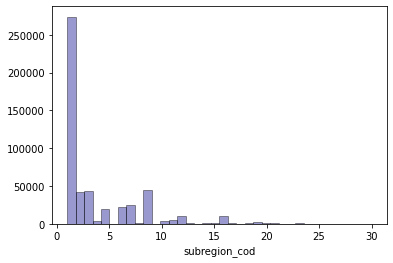

In [577]:
# Посмотрим на распределение категориального признака subregion: 
sns.distplot(df1['subregion_cod'], kde=False, rug=False, color='darkblue', bins=int(
        180/5), hist_kws={'edgecolor': 'black'})
print(df1['subregion'].value_counts())

<AxesSubplot:title={'center':'Медианный рейтинг отелей для признака continent'}, xlabel='continent', ylabel='reviewer_score'>

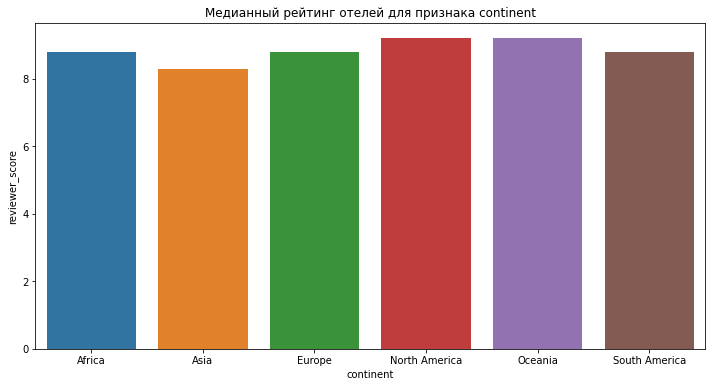

In [578]:
df_bar = df1[df1['sample'] == 1].groupby(
    by=['continent'],
    as_index=False
)[['reviewer_score']].median()
fig, (ax1) = plt.subplots(figsize=(12, 6))
ax1.set_title('Медианный рейтинг отелей для признака continent')
sns.barplot(
    data=df_bar,
    x='continent',
    y='reviewer_score',
    orient='v'
)

<AxesSubplot:title={'center':'Медианный рейтинг отелей для признака continent'}, xlabel='subregion', ylabel='reviewer_score'>

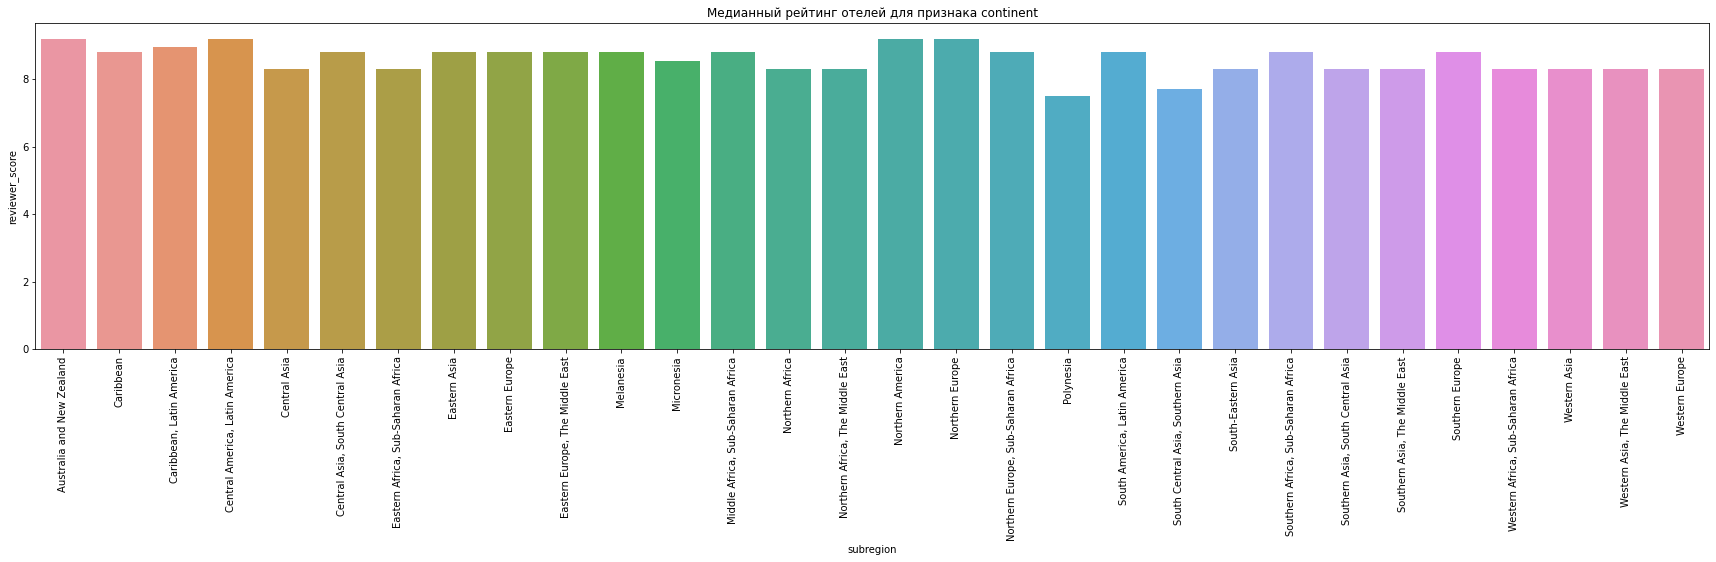

In [579]:
df_bar = df1[df1['sample'] == 1].groupby(
    by=['subregion'],
    as_index=False
)[['reviewer_score']].median()
fig, (ax1) = plt.subplots(figsize=(30, 6))
ax1.set_title('Медианный рейтинг отелей для признака continent')
plt.xticks(rotation=90)
sns.barplot(
    data=df_bar,
    x='subregion',
    y='reviewer_score',
    orient='v'   
)

Основное количество рецензентов из Северной Европы, преимущественно из Великобритании (почти половина всех рецензентов). Меньше всего туристуов из бедных стран Южной и Центральной Азии и Центальной Африки.

Это вполне вероятно, поскольку великобританцы самые заядлые путешественники и привыкли даже на выходные выезжать из дома. Это также объясняет, почему Лондон -самый популярный город среди рецензентов.

Из графиков по субрегионам и континентам видно, что рецензенты из Северной Америки и части Европы (Северная Европа) ставят самые высокие оценки. Однако нельзя сказать, что полученные признаки сильно влияют на целевую переменную. Кроме Полинезии, всех остальных регионов медианный рейтинг выше 8.

### tags

Признак с хештегами имеет тип строки, создадим список из 20 самых популярных хештегов и создадим на их основе бинарные признаки. Предварительно создадим числовой признак количество хештегов в строке (**tags_cnt**).

In [580]:
def re_func(num_tags):
    """
    Функция для преобразования строки в список
    """
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

df1['tags_new'] = df1['tags'].apply(re_func)
n_tags = df1.explode('tags_new')

# количество хештегов в строке (tags_cnt)
df1['tags_cnt'] = df1['tags_new'].apply(lambda x: len(x))

Была попытка создания признака по количеству заявленных ночей из признака *tags* , но после экспериментов, метрика только ухудшилась. Поэтому было принято решение остановиться на 20 признаках. Понятно, что более детальная проработка этого признака должна улучшить метрику, но пока остановимся на этом простом, хоть и спорном решении. Ниже код по созданию этого признака.

``` python 
list_nights = list(n_tags[n_tags['tags_new'].str.contains(r'\bStayed')]['tags_new'].value_counts().index)
# list_nights


def tags_nights(col, list_t):
    col = col[2:-2]                      # преобразование строки в список
    col = col.strip().split(' \', \' ')
    
    for i in range(len(col)):            # озозначение других хештегов нулями
        if col[i] in list_t:
            col[i] = col[i]
        elif col[i] not in list_t:
            col[i] = 0
        else:
            nan
    for c in col:                         # удаление хештегов с нулями
        if c == 0:
            col.remove(c)
        else:
            c = c

    for c in col:
        if c == 0:
            col.remove(c)
        else:
            c = c

    if len(str(col).split(' ')) > 1:        # преобразование строки в целое число по количеству ночей
        col = int(str(col).split(' ')[-2])
    elif len(str(col).split(' ')) <= 1:     # пустые значения заполняем самым популярным значение=1 
        col = 1                             # (таких всего 146)
                            
    return col


# применим функцию и создадим новый признак:
df1['stayed_nights'] = df['tags'].apply(
    lambda col: tags_nights(col, list_nights))


# функция для удаления хештегов из списка:
def remove_tags(col, list_t):
    for c in col:
        if c not in list_t:
            c = c
        else:
            col.remove(c)

    return col




df1['tags_new'] = df1['tags_new'].apply(lambda col: remove_tags(col, list_nights))

# coздадим список из n самых популярных хештегов:
n_tags = df1.explode('tags_new')
len(n_tags['tags_new'].unique())
list_tags = list(n_tags['tags_new'].value_counts()[:20].index)

```


In [581]:
list_tags = list(n_tags['tags_new'].value_counts()[:20].index)
list_tags

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room']

In [582]:
print(df1['tags_new'][386802])
def tags_pup(col, list_tags):
    """
    Фунция для переименования остальных столбцов в списке в "другие"
    """
    for i in range(len(col)):
        if col[i] in list_tags:
            col[i]=col[i]
        else:
            col[i]='other'
    return col
df1['tags_new']= df1['tags_new'].apply(lambda col: tags_pup(col, list_tags))
print(df1['tags_new'][386802])

['Leisure trip', 'Couple', 'Standard Twin Room', 'Stayed 3 nights']
['Leisure trip', 'Couple', 'other', 'Stayed 3 nights']


In [583]:
# добавим 21-ый хештег в наш список:
print(len(list_tags))
list_tags.append('other')
print(len(list_tags))

20
21


In [584]:
def contains(col):  
    """
    Функция для кодировки строки по хештегу
    """
    if x in col:  # Если хештег в текущей строке,
        return 1  # возвращаем значение 1
    else:  # Если хештега нет в текущей строке,
        return 0  # возвращаем значение 0


for x in list_tags:
    df1[x] = df1['tags_new'].apply(contains)

In [585]:
object_columns = [s for s in df1.columns if df1[s].dtypes == 'object']
object_columns

['hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'hotel_country',
 'hotel_city',
 'scсores_negrev',
 'scсores_posrev',
 'country',
 'subregion',
 'continent',
 'tags_new']

In [586]:
# удалим все признаки с типом "object":
df1.drop(object_columns, axis=1, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   days_since_review                           515431 non-null  int64  
 7   lat                                         515431 non-null  float64
 8   lng                                         515431 non-null  float64
 9   sample                                      515431 non-null  int64  
 

# Отбор признаков

Разделим признаки на числовые(непрерывные) и категориальные(дискретные).

In [587]:
#  список числовых признаков
num_cols = [
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'distance_to_center',
    'neg_negrev',
    'neu_negrev',
    'pos_negrev',
    'compound_negrev',
    'neg_posrev',
    'neu_posrev',
    'pos_posrev',
    'compound_posrev',
    'tags_cnt',
    'density'
]
#  список категориальных признаков
cat_cols = [
    'average_score',
    'lat',
    'lng',
    'review_month',
    'review_weekday',
    'hotel_chain',
    'hotel_cod',
    'hotel_city_cod',
    'native_hotel',
    'cnt_reviewer_nationality',
    'rank',
    'continent_prop',
    'continent_cod',
    'subregion_prop',
    'subregion_cod',
    'Leisure trip',
    'Submitted from a mobile device',
    'Couple',
    'Stayed 1 night',
    'Stayed 2 nights',
    'Solo traveler',
    'Stayed 3 nights',
    'Business trip',
    'Group',
    'Family with young children',
    'Stayed 4 nights',
    'Double Room',
    'Standard Double Room',
    'Superior Double Room',
    'Family with older children',
    'Deluxe Double Room',
    'Double or Twin Room',
    'Stayed 5 nights',
    'Standard Double or Twin Room',
    'Classic Double Room',
    'other'
]

In [588]:
print(len(num_cols))
print(len(cat_cols))

17
36


<AxesSubplot:>

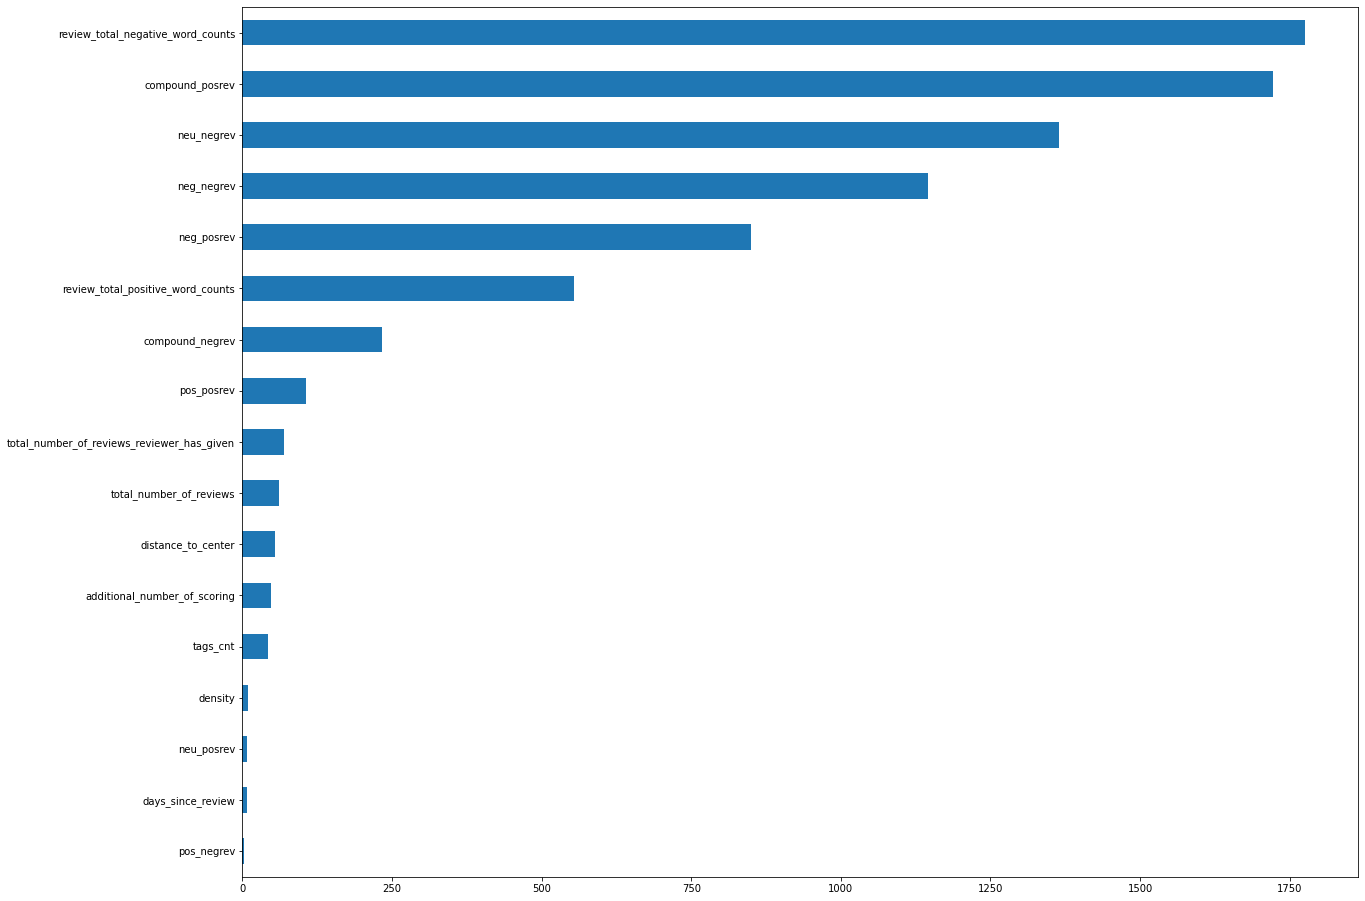

In [589]:
#  с помошью теста ANOVA (делали ранее) оценим важность влияния числовых признаков на целевую переменную:
fig = plt.subplots(figsize=(20, 16))
imp_num = pd.Series(f_classif(df1[num_cols], df1['reviewer_score'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:title={'center':'КОРРЕЛЯЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ'}>

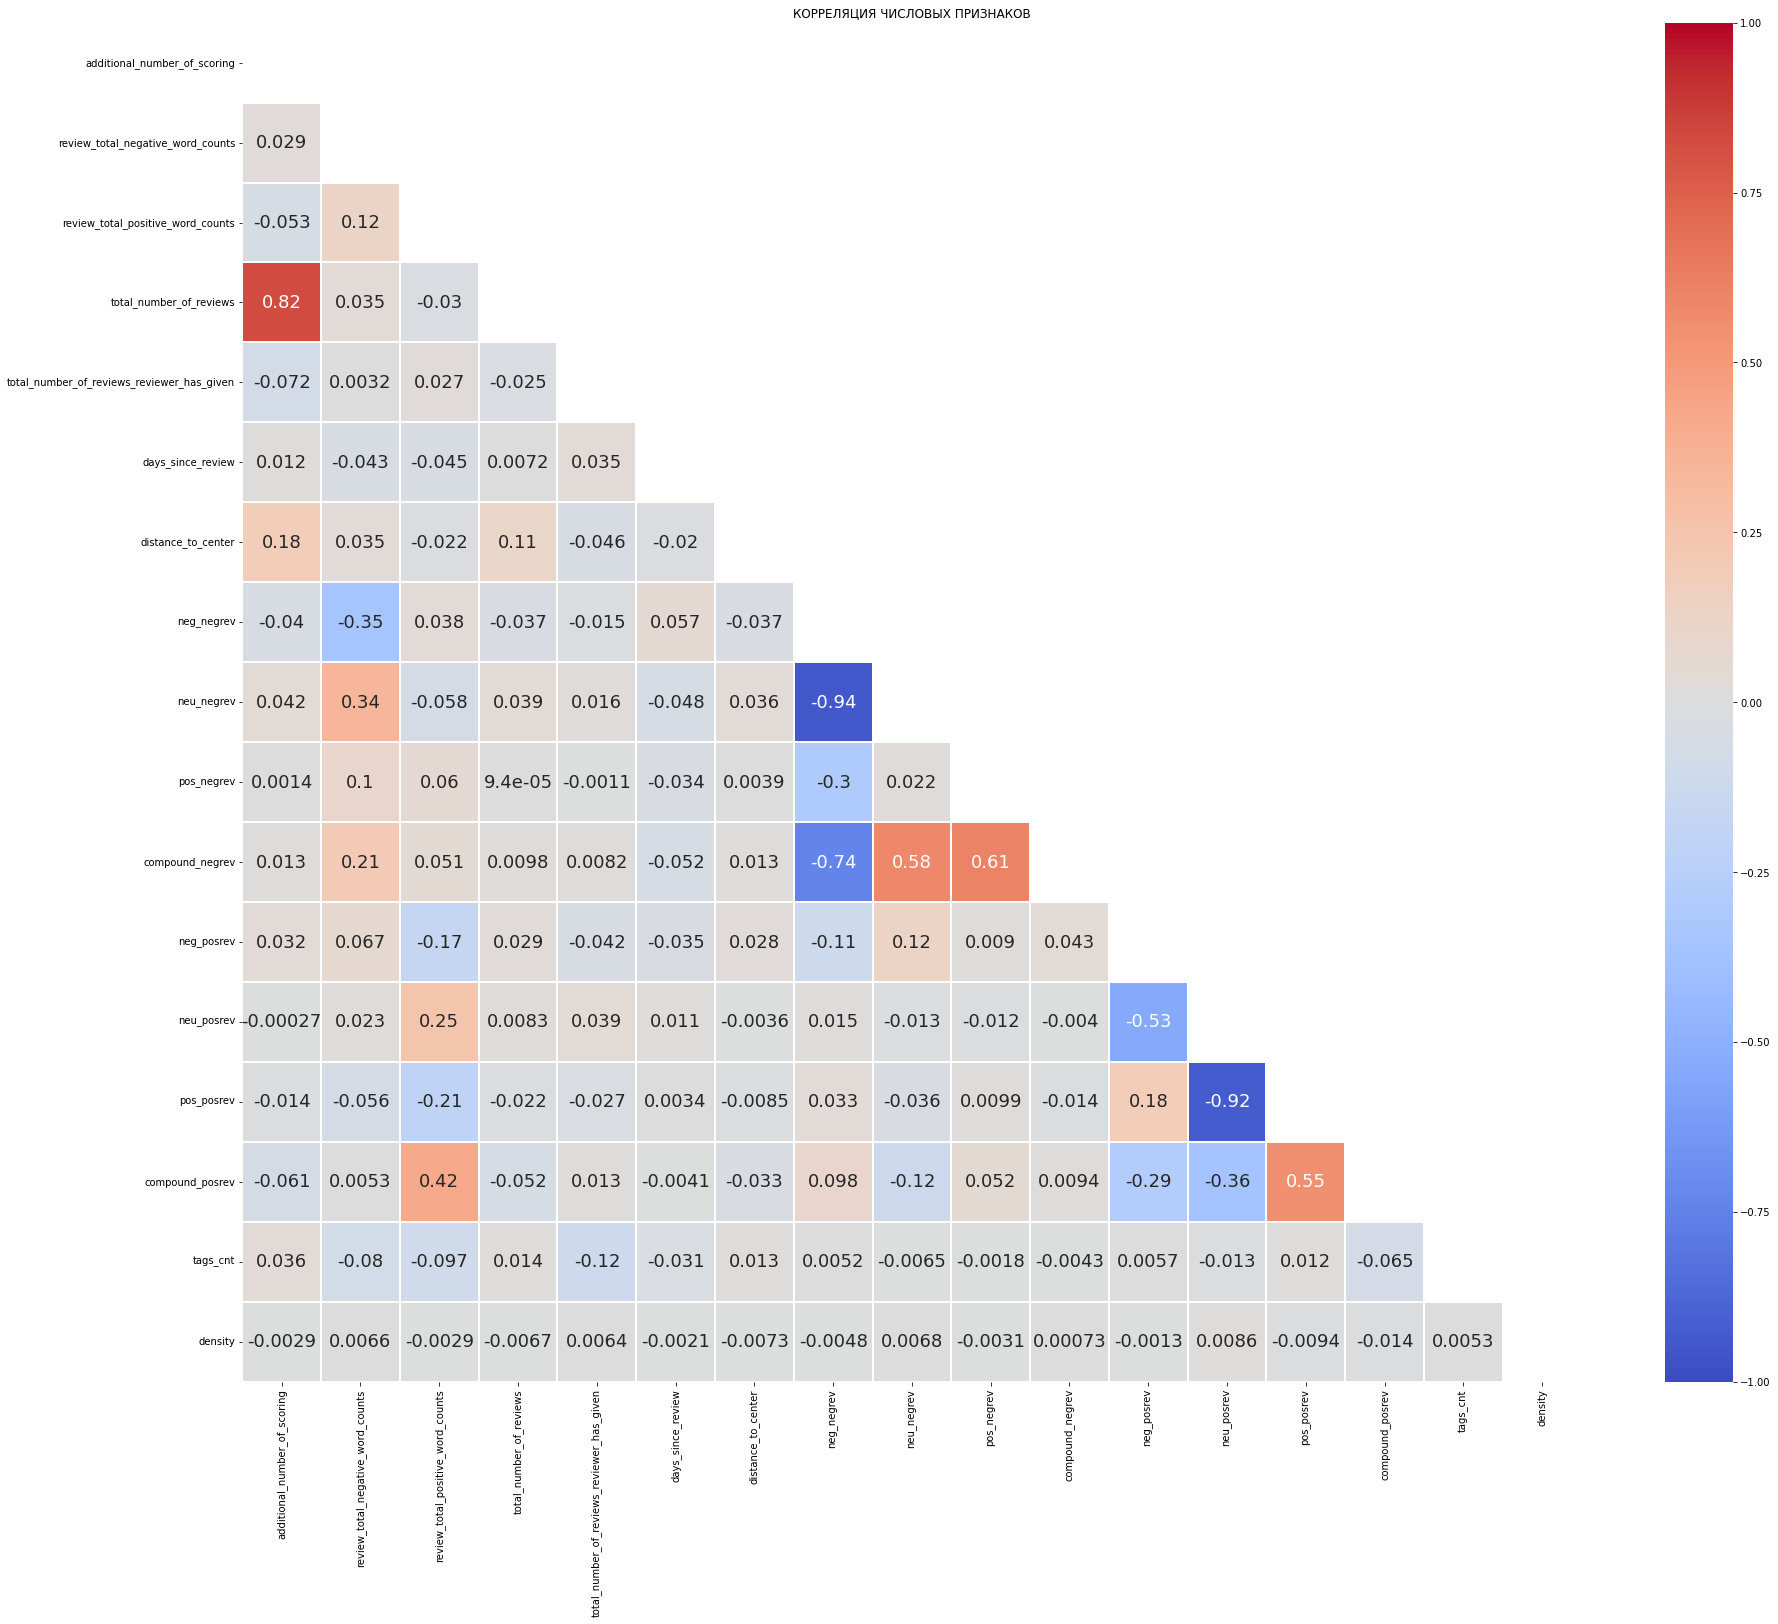

In [590]:
fig, ax1 = plt.subplots(figsize=(30, 25))
ax1.set_title('КОРРЕЛЯЦИЯ ЧИСЛОВЫХ ПРИЗНАКОВ')
matrix = np.triu(df1[num_cols].corr())
sns.heatmap(df1[num_cols].corr(), annot=True, vmin=-1, vmax=1, center=0,
            cmap='coolwarm', annot_kws={"size": 18}, linewidths=.1, mask=matrix)

Есть числовые признаки, которые сильно коррелируют друг с другом, однако опытным путем выяснилось, что удаление хотябы одного признака ухудшает метрику.

In [591]:
# признаки под возможное удаление:
num_cols_corr =['neu_negrev', 'neu_posrev','additional_number_of_scoring']

Посмотрим на важность категориальных признаков с помощью метода mutual_info_classif , который больше подходит для разряженных данных. В наших категориальных переменных много бинарных признаков. Кроме того, он может работать с отрицательными значениями в отличии от метода chi2.

<AxesSubplot:>

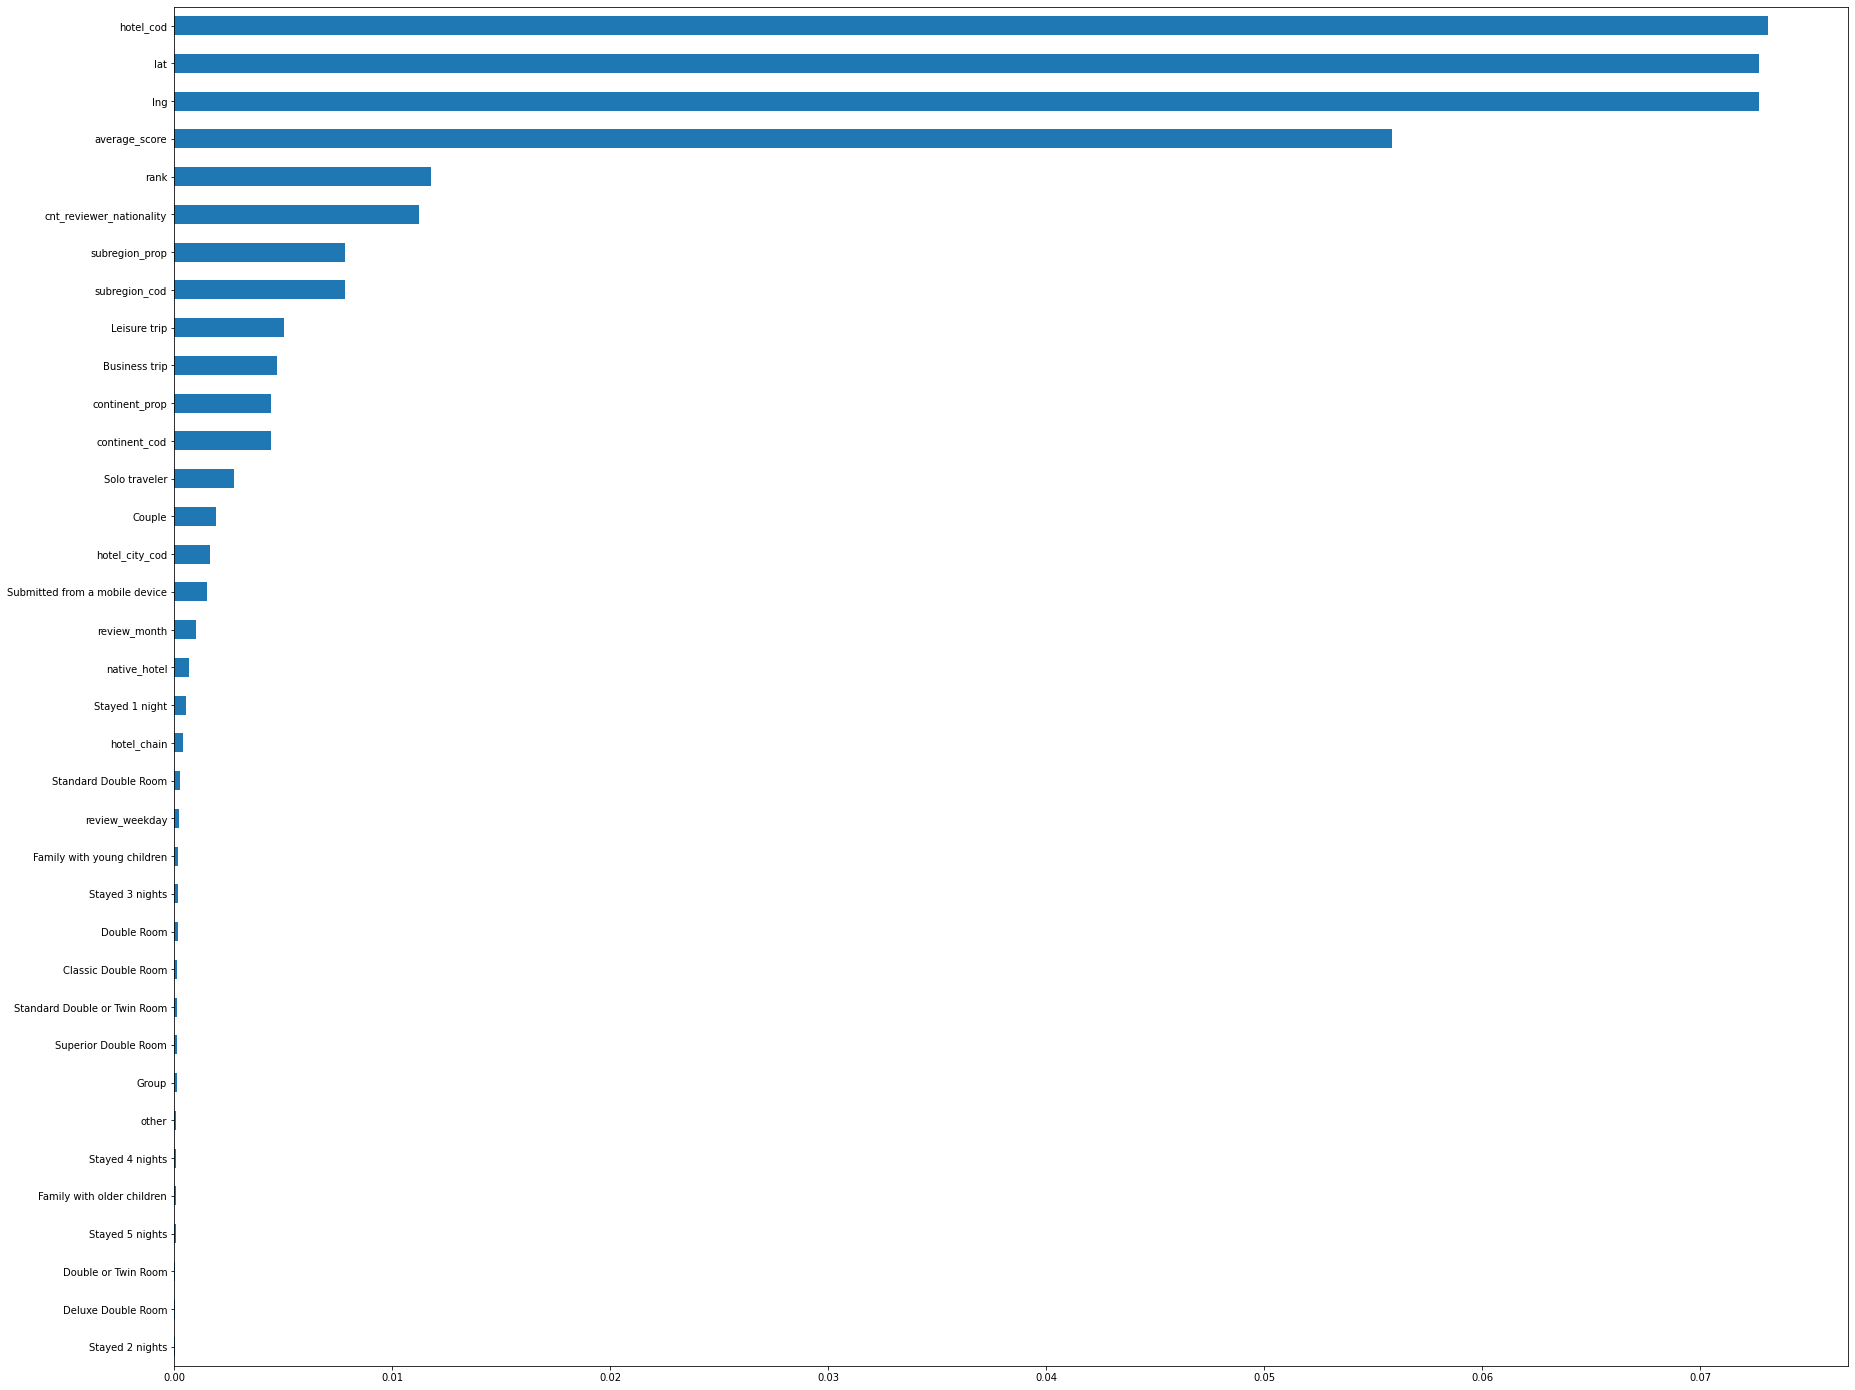

In [592]:
y=10*df1['reviewer_score'].astype('int')
fig = plt.subplots(figsize=(30, 25))
imp_cat = pd.Series(mutual_info_classif(df1[cat_cols], y,
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Из предыдущего теста выделятся сразу несколько признаков, которые больше оказывают влияние на целевую перемкенную, чем другие. В любом случае надо проверять на практике постоения модели, возможно и удалять ничего не нужно.

Посмотрим на корреляцию категориальных признаков.

<AxesSubplot:title={'center':'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ'}>

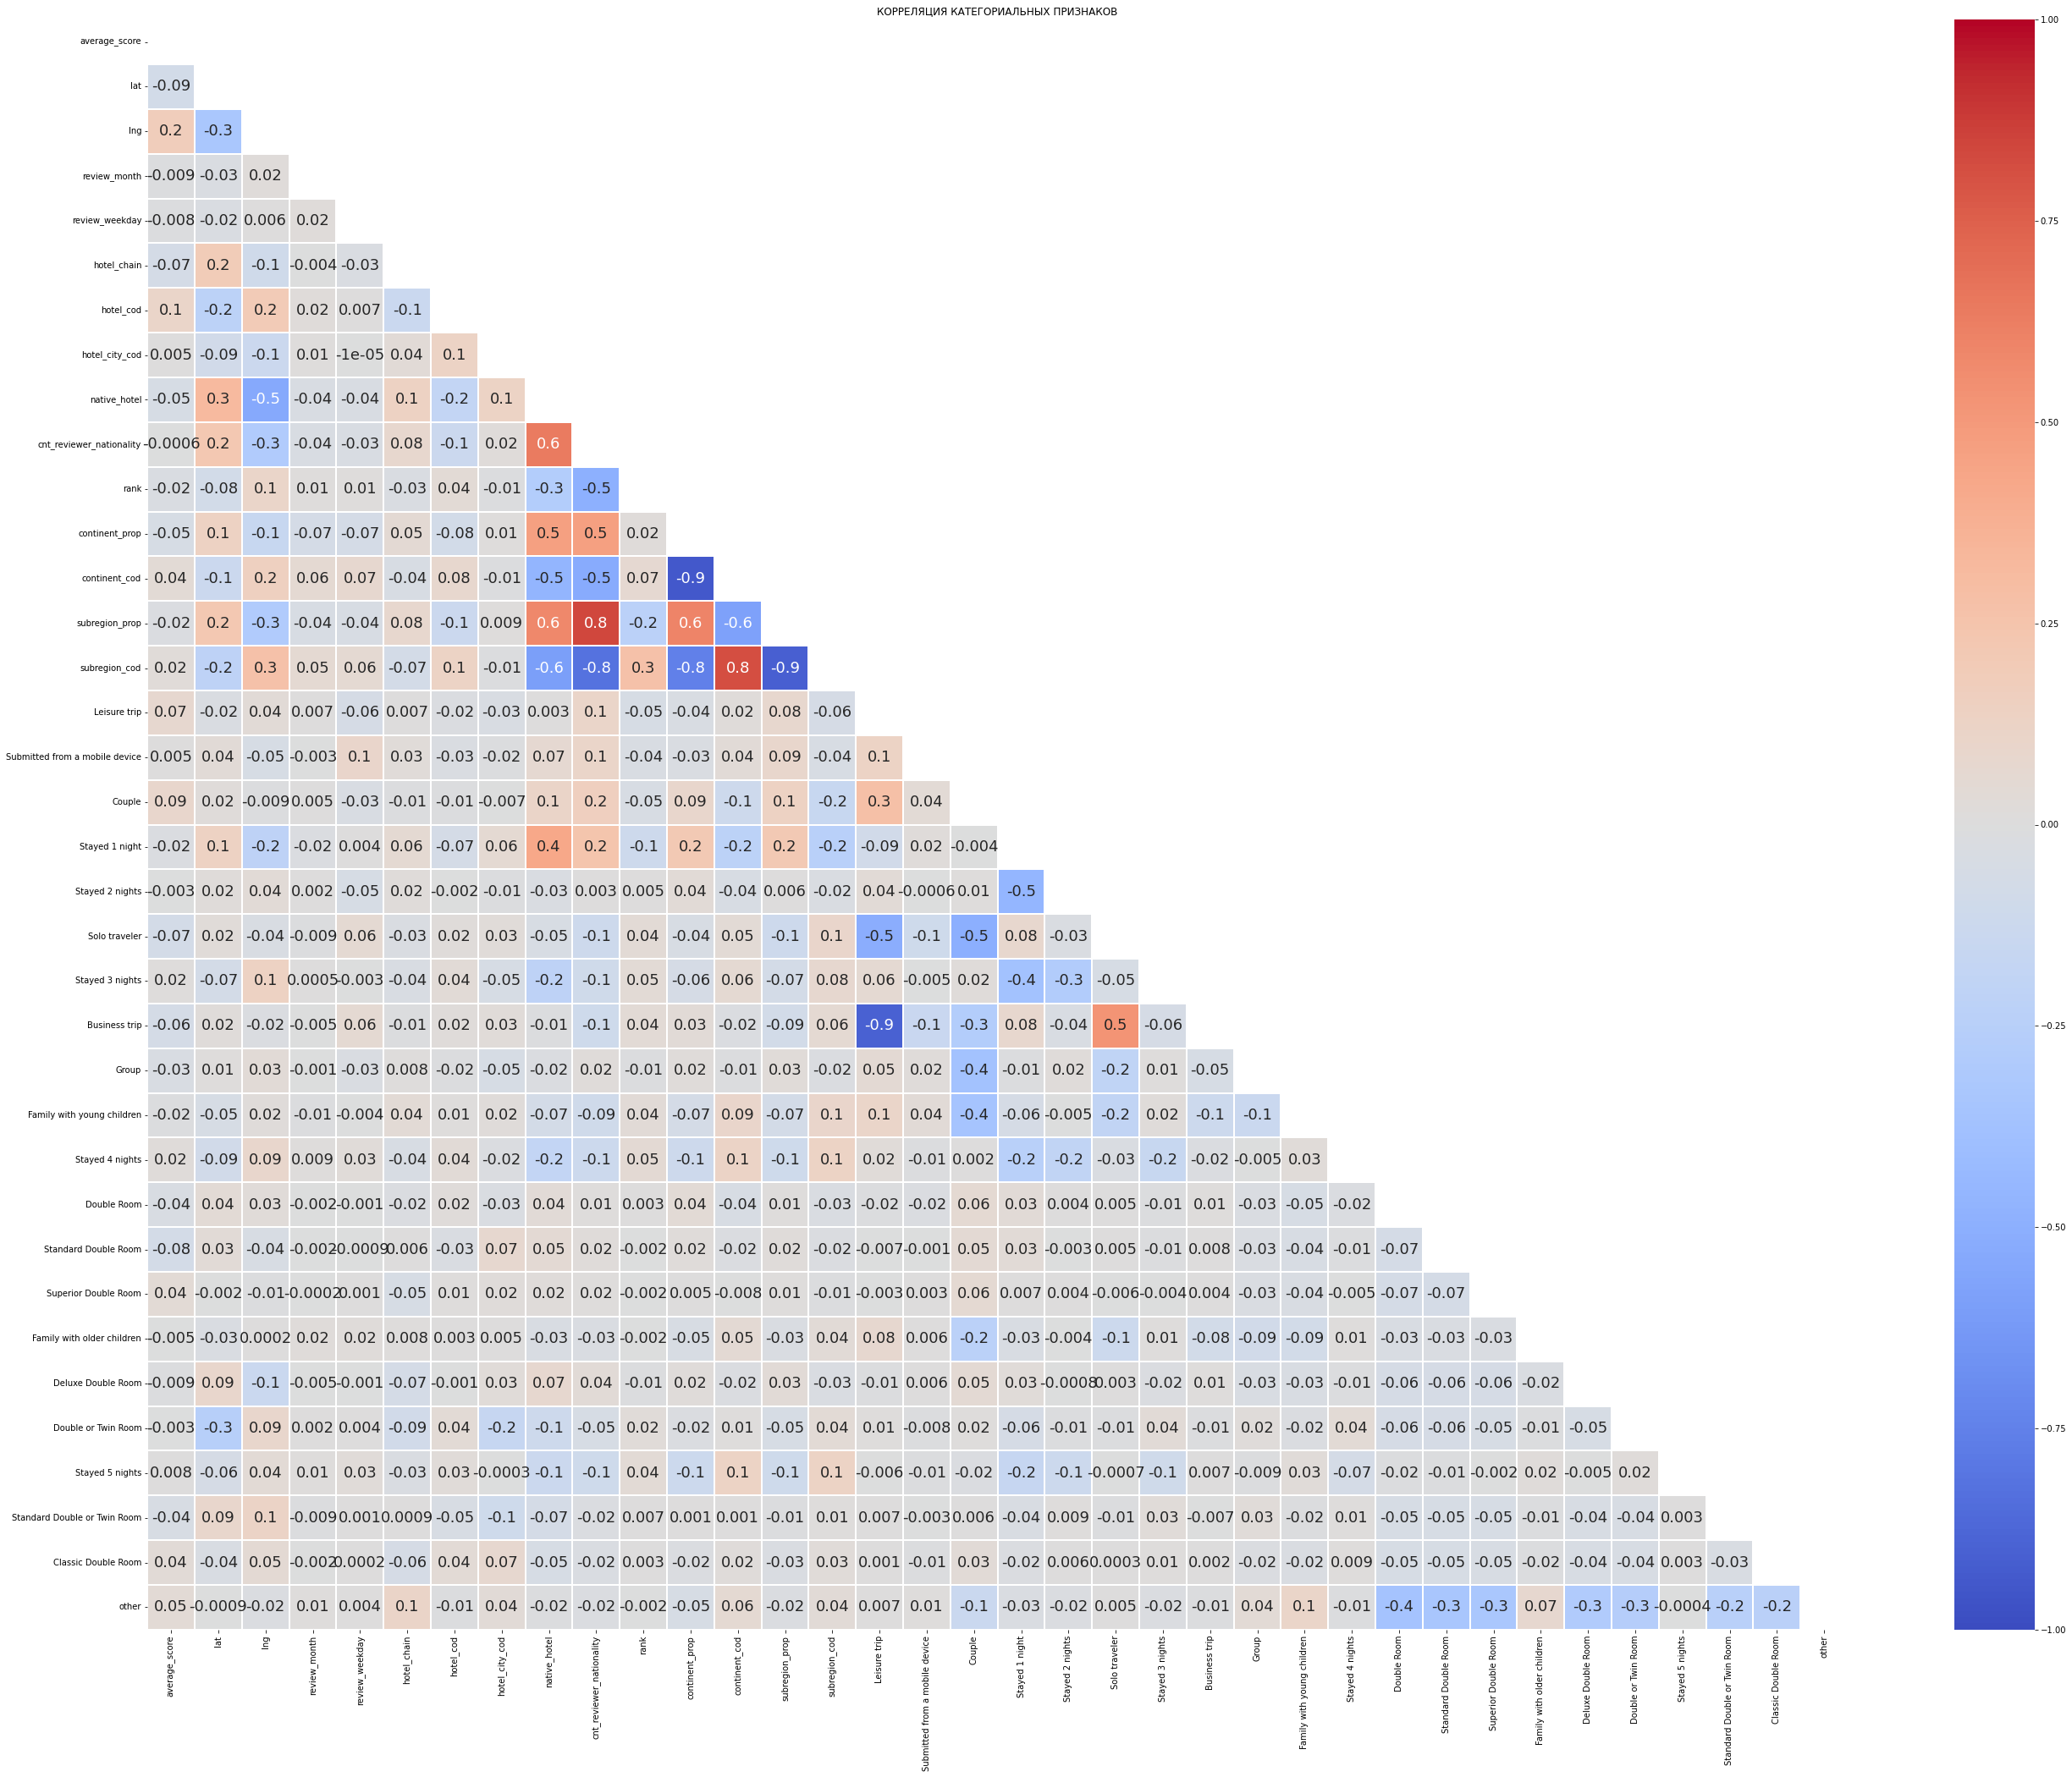

In [593]:
fig, (ax1) = plt.subplots(figsize=(45, 35))
ax1.set_title('КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ')
matrix = np.triu(df1[cat_cols].corr(method='spearman'))

sns.heatmap(df1[cat_cols].corr(method='spearman'), annot=True,
            vmin=-1, vmax=1, center=0, cmap='coolwarm', fmt='.1g', annot_kws={"size": 18}, linewidths=.1, mask=matrix)

In [594]:
# признаки под возможное удаление:
cat_cols_corr =['Business trip', 'subregion_prop', 'continent_cod']

Следует отметить, что удаление некоторых признаков ухудшает модель. Поэтому в конечном итоге признаки все оставили.

In [595]:
# варианты удаления признаков:
df2 = df1.drop(df1[num_cols_corr], axis=1)
df3 = df1.drop(df1[num_cols_corr + cat_cols_corr], axis=1)
df4 = df1.drop(df1[cat_cols_corr], axis=1)

In [596]:
#df4.info()

# Преобразование признаков


Посмотрим на наши числовые признаки. Изначально некоторые из них содержали выбросы, поэтому эти признаки будем нормализовывать их с помощью *RobustScaler*, который не чувствителен к выбросам. Часть числовых прихнаков не нуждается в нормализации, т.к. их значения не превышает 1. У части признаков нет выбросов, поэтому их будем нормализовывать с помощью *MinMaxScaler*

In [597]:
df1[num_cols].describe()

,additional_number_of_scoring,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review,distance_to_center,neg_negrev,neu_negrev,pos_negrev,compound_negrev,neg_posrev,neu_posrev,pos_posrev,compound_posrev,tags_cnt,density
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,498.275079,18.539760,17.777342,2744.259084,7.165215,354.405492,3.143575,0.321199,0.618545,0.054882,-0.202931,0.034806,0.575996,0.388608,0.593839,4.569391,324.320179
std,500.618961,29.690973,21.803204,2317.823718,11.038742,208.915335,2.578668,0.410683,0.392950,0.118777,0.456514,0.103249,0.273979,0.235496,0.342038,0.520182,983.533443
min,1.000000,0.000000,0.000000,43.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.998100,0.000000,0.000000,0.000000,-0.983200,1.000000,0.311400
25%,169.000000,2.000000,5.000000,1161.000000,1.000000,175.000000,1.313850,0.000000,0.000000,0.000000,-0.709600,0.000000,0.408000,0.230000,0.361200,4.000000,86.460400
50%,342.000000,9.000000,11.000000,2134.000000,3.000000,353.000000,2.531275,0.104000,0.781000,0.000000,-0.153100,0.000000,0.587000,0.404000,0.708900,5.000000,279.985100
75%,660.000000,23.000000,22.000000,3633.000000,8.000000,527.000000,4.116124,1.000000,1.000000,0.061000,0.000000,0.000000,0.752000,0.588000,0.883400,5.000000,279.985100
max,2682.000000,408.000000,395.000000,16670.000000,355.000000,730.000000,17.302738,1.000000,1.000000,1.000000,0.996000,1.000000,1.000000,1.000000,0.999300,6.000000,21402.705200


In [598]:
# для нормализации, стандартизации
from sklearn import preprocessing

# инициализируем нормализаторы:
r_scaler = preprocessing.RobustScaler()
r_minmax = preprocessing.MinMaxScaler()

cols_robust=['additional_number_of_scoring', 'review_total_negative_word_counts','review_total_positive_word_counts',
             'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given'] 
cols_minmax=['days_since_review','distance_to_center', 'tags_cnt', 'density']
# кодируем часть признаков:
df_robust = r_scaler.fit_transform(df1[cols_robust])
df_robust = pd.DataFrame(df_robust , columns=cols_robust)

df_minmax = r_minmax.fit_transform(df1[cols_minmax])
df_minmax = pd.DataFrame(df_minmax , columns=cols_minmax)
# делаем копию и записываем данные в копию

df_rs_mm = df1.copy()
df_rs_mm[cols_robust] = df_robust[cols_robust]
df_rs_mm[cols_minmax] = df_minmax[cols_minmax]
df_rs_mm.shape

(515431, 55)

# Моделирование

In [599]:
#df1.hist(figsize=(16,14))

```python
# Теперь выделим тестовую часть
train_data = df1.query('sample == 1').drop(['sample'], axis=1)
test_data = df1.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)
```

In [600]:
# Теперь выделим тестовую часть
train_data = df_rs_mm.query('sample == 1').drop(['sample'], axis=1)
test_data = df_rs_mm.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [601]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [602]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 54), (386496, 54), (386496, 53), (289872, 53), (96624, 53))

In [603]:
# Создаём модель  
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [604]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [605]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8739313183060107


In [606]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE(y_test, y_pred)

12.507741191367266

In [607]:
#MAPE(y_test, y_pred)

<AxesSubplot:>

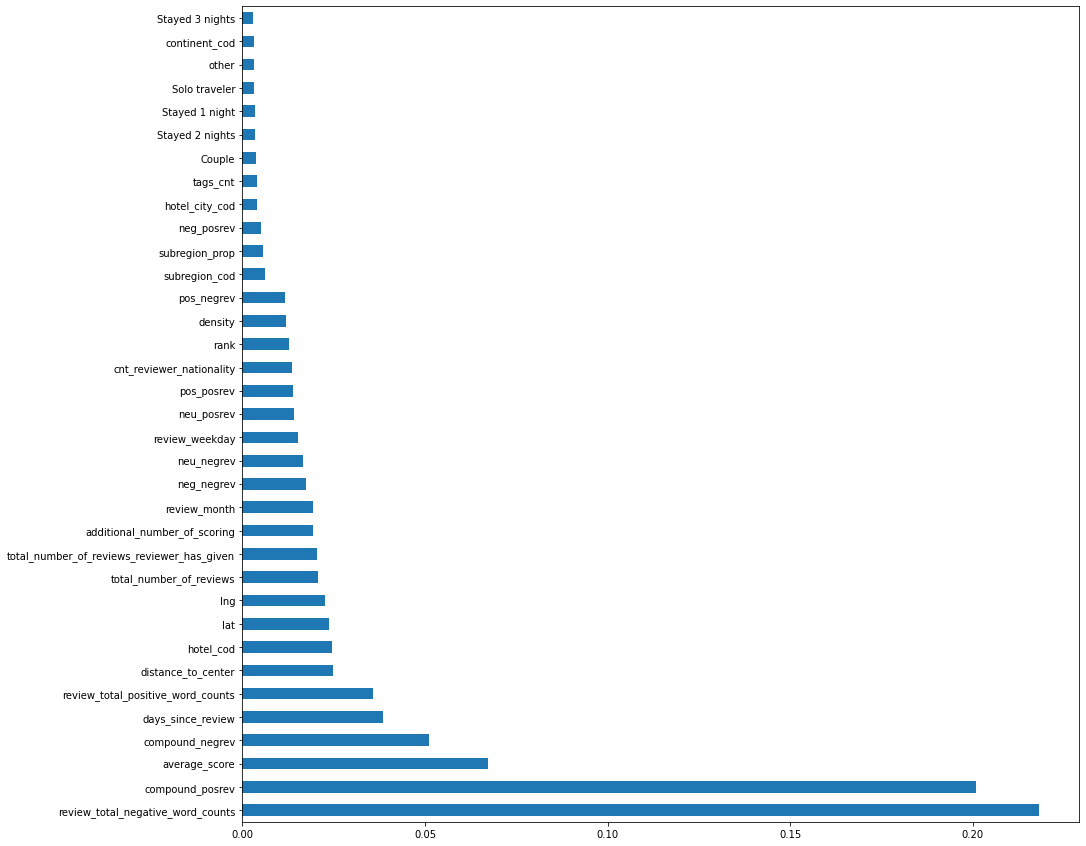

In [608]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15,15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(35).plot(kind='barh')

In [609]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [610]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [611]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [612]:
predict_submission

array([8.649, 7.378, 8.295, ..., 8.114, 9.569, 7.406])

In [613]:
list(sample_submission)

['reviewer_score', 'id']

In [614]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_add_8_rs_mm.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.649,488440
1,7.378,274649
2,8.295,374688
3,9.664,404352
4,9.346,451596
5,8.604,302161
6,7.775,317079
7,7.714,13963
8,8.426,159785
9,7.304,195089


# ВЫВОД:

В результате построения модели финальная метрика получилась на уровне 12,58992.
При постоении модели были использованы предоставленные данные, а также некоторая информация из внешних источников, касаема стран проживания рецензентов.

Из полученных признаков, самое большое влияние на целевую переменную оказывают признаки , связанные с оценков отзывов, количество дней между датой проверки и очистки, средний балл отеля и признак - количество слов в негативном отзыве.

Это весьма правдоподобно, поскольку при выборе люди отеля часто орентируются на отрицательные отзывы и на сколько много в них написано. 

Также имеет значение и место нахождения отеля, в частности удаленность от центру города.

Наименьше влияние оказывают хештеги, национальность рецензетов, хотя можно сделать вывод, что рецензенты из Северной Америки и Северной Европы дают самые высокие оценки отелям. Возможно, они выбирают более дорогие отели с первоклассным обслуживанием и высоким рейтингом и отель оправдывает их ожидания.

При построении модели была использована нормализация некоторых числовых признаков. Она дала небольшое улучшение показателей модели. Стандартизация признаков не проводилась, посколько мало с нормальным распределением.



Возможности улучшения: 

* признак с хештегами проработан не до конца. При его обработке был выбран самый простой вариан. Лучше всего сгруппировать хештеги по группам и уже потом проводить однократное кодирование;

* возможно стоит заполнитеть пропуски точными коррдинатами отелей.
 



In [615]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)